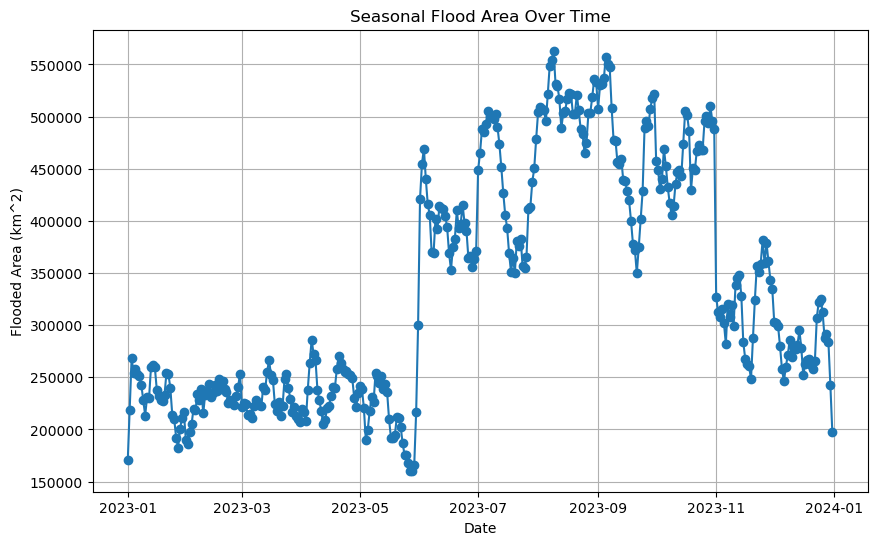

In [2]:
import os
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.transform import Affine

# -------------------------------
# 1. 读取所有GeoTIFF并存为三维数组 pixel_series (T x Height x Width)
#    以及对应的 timestamps 列表 (长度为 T)
# -------------------------------

input_folder = r'G:/Public/CYGNSS_clip_csv/Merged_data/Random_forest_training_with_time/daily_rasters_tif'

tif_files = sorted(
    [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.tif')]
)

pixel_series = []
timestamps = []
transform = None
crs = None

for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        data = src.read(1)  # assuming single-band
        pixel_series.append(data)
        if transform is None:
            transform = src.transform
            crs = src.crs
        
        filename = os.path.basename(tif_file).split('.')[0]
        try:
            date_str = filename.split('_')[-1]  # e.g. something_20230101
            timestamps.append(pd.to_datetime(date_str, format='%Y%m%d'))
        except:
            timestamps.append(pd.NaT)

pixel_series = np.array(pixel_series)
timestamps = np.array(timestamps)

valid_mask = ~pd.isna(timestamps)
pixel_series = pixel_series[valid_mask, ...]
timestamps = timestamps[valid_mask]

# 按日期排序，确保时间升序
sort_idx = np.argsort(timestamps)
pixel_series = pixel_series[sort_idx, ...]
timestamps = timestamps[sort_idx]

# -------------------------------
# 2. 定义阈值，将 像元中散射系数明显更低(或水体比例更低) 时 判为“水或淹没”
#    这与之前“水体比例更高判水”相反
# -------------------------------
### 修改点：将逻辑翻转
water_threshold = 0.2  
# 以前： water_mask = (pixel_series > 0.2)
# 现在：当 pixel_series < 0.2 时，才认为是真正的水
water_mask = (pixel_series < water_threshold)

# -------------------------------
# 3. 排除“常年水体” 或者“常年干沙”？
#    视情况定义。如果你的数据里多数情况下都显示低值，可能真的是常年水。
# -------------------------------
time_length = water_mask.shape[0]

# 统计每个像元有多少天是“water_mask=True”
days_water = np.sum(water_mask, axis=0)  # shape: (H, W)
water_fraction_over_time = days_water / time_length

# permanent_water_threshold: 原本是 0.8
#   若像元 80% 的天数都 < 0.2，则它常年都是“低散射”
#   这通常被认为是常年水体(湖泊/河道等)
permanent_water_threshold = 0.8

### 修改点：如果你的场景里“多数时候都很低”反而是干沙(被误以为水),
### 那你就需要更谨慎区分。下面先保持原逻辑：大部分时间都低 => 常年水。
permanent_water_mask = (water_fraction_over_time > permanent_water_threshold)

# -------------------------------
# 4. 季节性洪水识别 + 连续天数过滤
# -------------------------------
# (1) 除去常年水体
seasonal_water_mask = water_mask & (~permanent_water_mask[np.newaxis, :, :])

# (2) 对每个像元做“连续天数”过滤
min_flood_days = 3   
max_flood_days = 90  

def filter_by_consecutive_days(bin_series_1d, min_days, max_days):
    result = np.zeros_like(bin_series_1d, dtype=bool)
    start_idx = None
    for i in range(len(bin_series_1d)):
        if bin_series_1d[i] and start_idx is None:
            start_idx = i
        if (not bin_series_1d[i] or i == len(bin_series_1d) - 1) and start_idx is not None:
            end_idx = i if not bin_series_1d[i] else i + 1
            length = end_idx - start_idx
            if min_days <= length <= max_days:
                result[start_idx:end_idx] = True
            start_idx = None
    return result

T, H, W = seasonal_water_mask.shape
seasonal_flood_mask_filtered = np.zeros((T, H, W), dtype=bool)

for r in range(H):
    for c in range(W):
        # 如果是常年水体像元，跳过
        if permanent_water_mask[r, c]:
            continue
        pixel_bool_1d = seasonal_water_mask[:, r, c]
        seasonal_flood_mask_filtered[:, r, c] = filter_by_consecutive_days(
            pixel_bool_1d, min_flood_days, max_flood_days
        )

# -------------------------------
# 5. 计算逐日洪水面积
# -------------------------------
pixel_width = abs(transform.a)
pixel_height = abs(transform.e)
pixel_area = 5 * 5 
daily_flooded_pixels = np.sum(seasonal_flood_mask_filtered, axis=(1, 2))
daily_flooded_area = daily_flooded_pixels * pixel_area
daily_flooded_area_km2 = daily_flooded_area

# -------------------------------
# 6. 输出
# -------------------------------
df_flood = pd.DataFrame({
    'date': timestamps,
    'flooded_area_km2': daily_flooded_area_km2
})
df_flood.set_index('date', inplace=True)

import matplotlib.pyplot as plt

# 假设 df_flood 如下：
# index: date (DatetimeIndex)
# columns: 'flooded_area_km2'

plt.figure(figsize=(10, 6))
plt.plot(df_flood.index, df_flood['flooded_area_km2'], marker='o', linestyle='-')
plt.title("Seasonal Flood Area Over Time")
plt.xlabel("Date")
plt.ylabel("Flooded Area (km^2)")
plt.grid(True)
plt.show()

In [1]:
import ee
import pandas as pd
import datetime

# Authenticate (uncomment if needed to do interactive auth)
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize()

In [7]:
# Define your bounding box:
lon_min, lon_max = 10, 40
lat_min, lat_max = 5, 20
region = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

# Define date range for 2023
start_date = '2023-01-01'
end_date   = '2023-12-31'

# Access ERA5 daily data collection
era5_coll = (
    ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')
    .select('total_precipitation_sum')  # in meters
    .filterDate(start_date, end_date)
    .filterBounds(region)
)

def daily_precip_mean(image):
    """Returns a feature with daily mean total precipitation."""
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=25000,      # or an appropriate scale for ERA5 ~ 25 km
        bestEffort=True
    )
    # Extract the date from the image properties
    date = ee.Date(image.get('system:time_start')).format('yyyy-MM-dd')
    # Create a feature with date + the mean precipitation property
    return ee.Feature(None, {
        'date': date,
        'mean_precip': stats.get('total_precipitation_sum')
    })

# Map over the collection to get a feature collection of daily stats
daily_stats_fc = era5_coll.map(daily_precip_mean)

In [8]:
# Convert feature collection to a list of features
features_list = daily_stats_fc.toList(daily_stats_fc.size()).getInfo()

# Parse into a pandas DataFrame
dates = []
precip_values = []
for f in features_list:
    prop = f['properties']
    dates.append(prop['date'])
    # Convert meters of precipitation to mm (1 m = 1000 mm)
    # ERA5 total_precip is in meters/day
    precip = prop['mean_precip']
    if precip is None:
        precip_values.append(None)
    else:
        precip_values.append(float(precip) * 1000.0)

df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'mean_precip_mm_per_day': precip_values
})

df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(df.head())

        date  mean_precip_mm_per_day
0 2023-01-01                0.098044
1 2023-01-02                0.110141
2 2023-01-03                0.042738
3 2023-01-04                0.018718
4 2023-01-05                0.023727


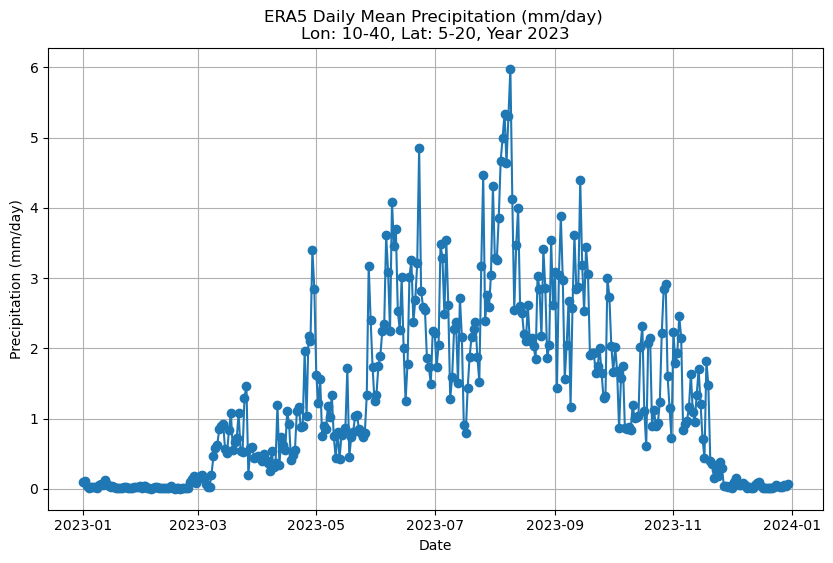

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['mean_precip_mm_per_day'], marker='o', linestyle='-')
plt.title('ERA5 Daily Mean Precipitation (mm/day) \nLon: 10-40, Lat: 5-20, Year 2023')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm/day)')
plt.grid(True)
plt.show()

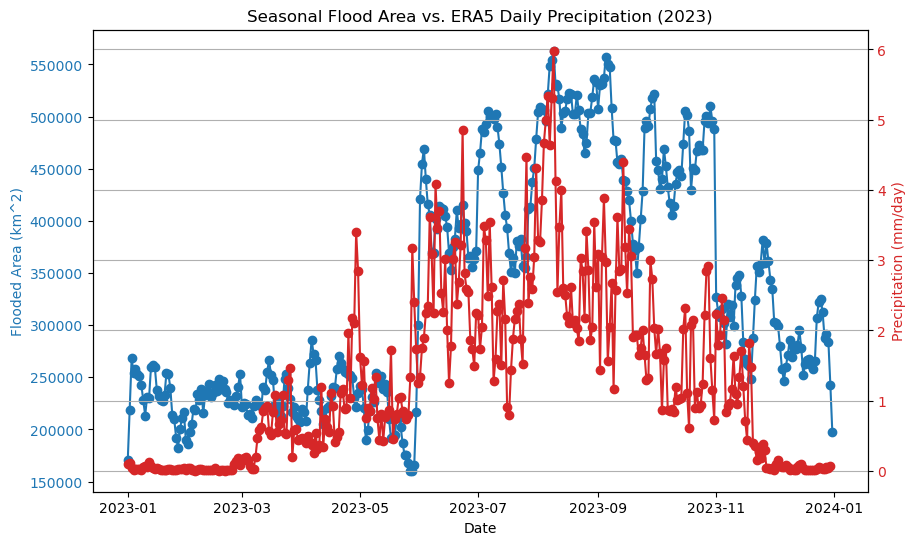

In [11]:
import matplotlib.pyplot as plt

# Assume you already have:
# df_flood: index=DatetimeIndex, column='flooded_area_km2'
# df: column='date' (Datetime), column='mean_precip_mm_per_day'

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Flooded Area on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Flooded Area (km^2)', color=color1)
ax1.plot(
    df_flood.index,
    df_flood['flooded_area_km2'],
    marker='o',
    linestyle='-',
    color=color1,
    label='Flooded Area'
)
ax1.tick_params(axis='y', labelcolor=color1)

# Create twin y-axis for Precipitation
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Precipitation (mm/day)', color=color2)
ax2.plot(
    df['date'], 
    df['mean_precip_mm_per_day'],
    marker='o',
    linestyle='-',
    color=color2,
    label='Precipitation'
)
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends, if desired
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Seasonal Flood Area vs. ERA5 Daily Precipitation (2023)')
plt.grid(True)
plt.show()

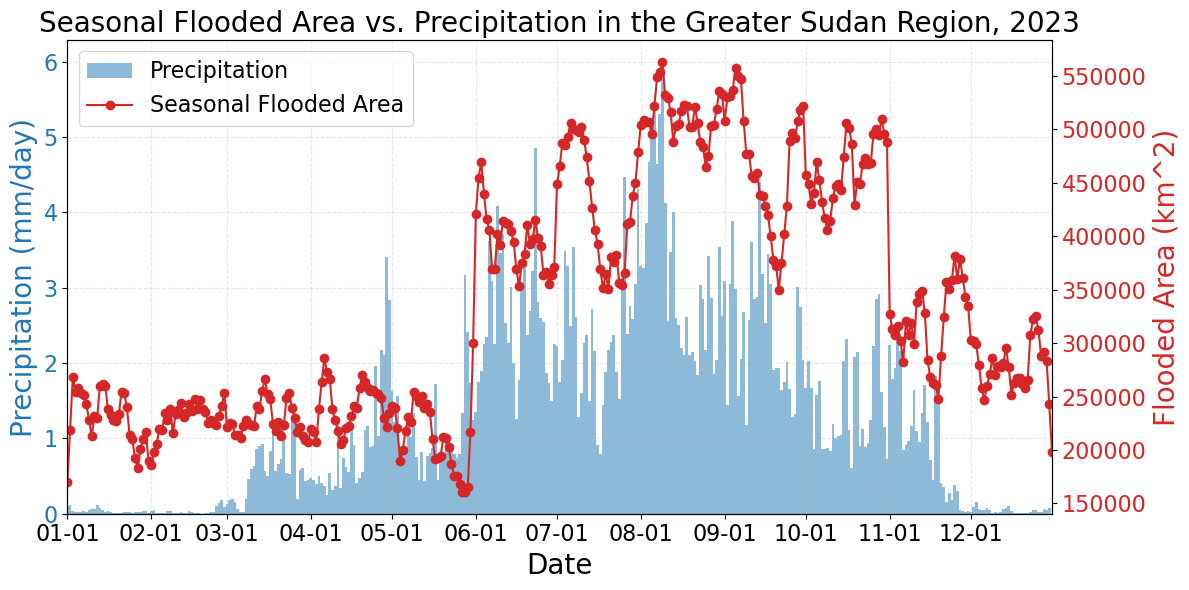

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Example DataFrames (already prepared):
#   - df_flood with index as DatetimeIndex, column 'flooded_area_km2'
#   - df       with columns 'date' (Datetime) and 'mean_precip_mm_per_day'

fig, ax1 = plt.subplots(figsize=(12, 6))

# === 3) Plot Precipitation (bar) on ax2 (Right Y-Axis) ===
color_precip = "tab:blue"

ax1.set_ylabel("Precipitation (mm/day)", color=color_precip, fontsize=20)
ax1.set_xlabel("Date", fontsize=20)

bar_precip = ax1.bar(
    df['date'],
    df['mean_precip_mm_per_day'],
    width=1.0,    # daily data => narrow bars
    align='center',
    color=color_precip,
    alpha=0.5,
    label='Precipitation'
)
ax1.tick_params(axis='y', labelsize=16, labelcolor=color_precip)
ax1.tick_params(axis='x', labelsize=16)

# Grid style
ax1.grid(True, which='major', linestyle='--', alpha=0.3)

# === 2) Format the X-axis for Dates, remove left/right margin ===
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=12))
fig.autofmt_xdate(rotation=0)  # rotation=0 => horizontal text

# Center-align the tick labels horizontally
for label in ax1.get_xticklabels():
    label.set_ha("center")

# To remove extra white space at the edges, set X-limits tightly to data
min_date = min(df_flood.index.min(), df['date'].min())
max_date = max(df_flood.index.max(), df['date'].max())
ax1.set_xlim([min_date, max_date])

# === 3) Plot Flooded Area (line) on ax1 (Left Y-Axis) ===
ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color_flood = "tab:red"

ax2.set_xlabel("Date")
ax2.set_ylabel("Flooded Area (km^2)", color=color_flood, fontsize=20)
line_flood = ax2.plot(
    df_flood.index,
    df_flood['flooded_area_km2'],
    marker='o',
    linestyle='-',
    color=color_flood,
    label='Seasonal Flooded Area'
)

# Increase tick-label font size on both axes
ax2.tick_params(axis='y', labelsize=16, labelcolor=color_flood)
ax2.tick_params(axis='x', labelsize=16)

# === 4) Combine legends & set title ===
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=16)

plt.title("Seasonal Flooded Area vs. Precipitation in the Greater Sudan Region, 2023", fontsize=20)
plt.tight_layout()
plt.show()

代表性日期索引： [0, 121, 243, 364]
对应日期： [Timestamp('2023-01-01 00:00:00') Timestamp('2023-05-02 00:00:00')
 Timestamp('2023-09-01 00:00:00') Timestamp('2023-12-31 00:00:00')]


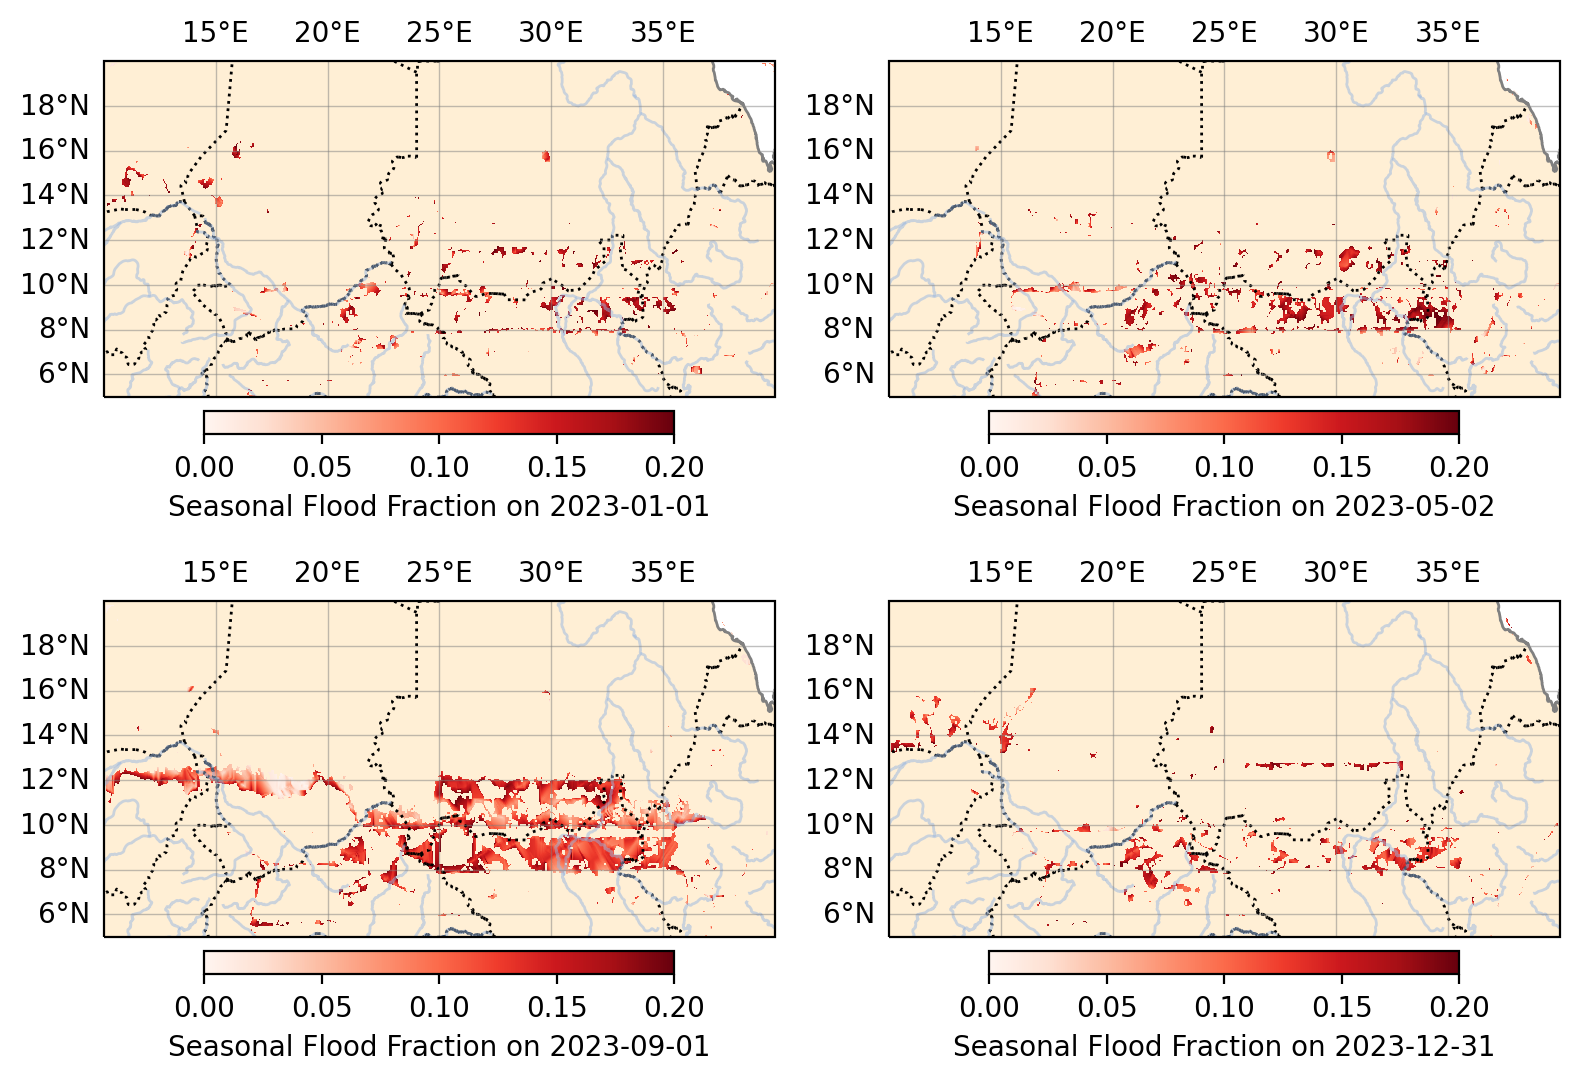

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设已有以下变量
# pixel_series: shape (T, H, W)，存放"water fraction"或散射系数等
# seasonal_flood_mask_filtered: shape (T, H, W)，布尔型，True=最终判定为季节性洪水
# timestamps: 长度 T 的日期数组 (pd.DatetimeIndex 或 np.array(pd.Timestamp))
# transform: rasterio.transform.Affine (数据在 EPSG:4326 下)
# CRS: 如果需要，可指定 crs = ccrs.PlateCarree() 之类

# Step 1: 选取四个代表性日期
T = len(timestamps)
idx_list = [0, T//3, 2*T//3, T-1]  
idx_list = sorted(list(set(idx_list)))  # 去重并排序

print("代表性日期索引：", idx_list)
print("对应日期：", timestamps[idx_list])

# Step 2: 计算影像的地理范围 extent
H, W = pixel_series.shape[1], pixel_series.shape[2]
minx, maxy = transform * (0, 0)
maxx, miny = transform * (W, H)
extent = [minx, maxx, miny, maxy]

# Step 3: 在2×2子图中分别绘制，使用Cartopy
fig, axes = plt.subplots(
    2, 2, 
    figsize=(8, 5.8), dpi=200,
    subplot_kw={'projection': ccrs.PlateCarree()}  # 投影
)

for i, ax in enumerate(axes.flat):
    t_idx = idx_list[i]
    date_str = timestamps[t_idx].strftime('%Y-%m-%d')

    # (a) 取出该天的布尔掩膜 (True=seasonal flood)
    flood_bool = seasonal_flood_mask_filtered[t_idx, :, :]  # shape (H, W)

    # (b) 只保留洪水区域的像元值，其他位置置为NaN
    flood_fraction_map = np.where(flood_bool, pixel_series[t_idx, :, :], np.nan)
    ax.add_feature(cfeature.LAND, facecolor='papayawhip', zorder=0)

    # (c) 用 imshow 绘图
    im = ax.imshow(
        flood_fraction_map,
        origin='upper',
        cmap='Reds',
        vmin=0, vmax=0.2,
        extent=extent,  # 在地理坐标下的范围
        transform=ccrs.PlateCarree()  # 告诉imshow该数据是 PlateCarree 投影
    )

    #ax.set_title(f"Seasonal Flood Fraction on {date_str}", fontsize=12)

    # (d) 添加 Cartopy 特征
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    # ax.add_feature(cfeature.STATES)  # 如果需要州界线
    ax.add_feature(cfeature.RIVERS, alpha=0.5)  # 添加河流
    
    # (e) 设置范围（可选），如只想放大到具体区域
    # ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())

    # (f) 添加网格线
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = True    # 显示顶部标签
    gl.bottom_labels = False  # 隐藏底部标签
    gl.left_labels = True   # 显示左侧标签
    gl.right_labels = False   # 隐藏右侧标签
    
    # (g) Colorbar: 每个子图一个
    cbar = plt.colorbar(im, ax=ax, shrink=0.7,orientation='horizontal',fraction=0.05, pad=0.03)
    cbar.set_label(f"Seasonal Flood Fraction on {date_str}")

plt.tight_layout()
plt.show()

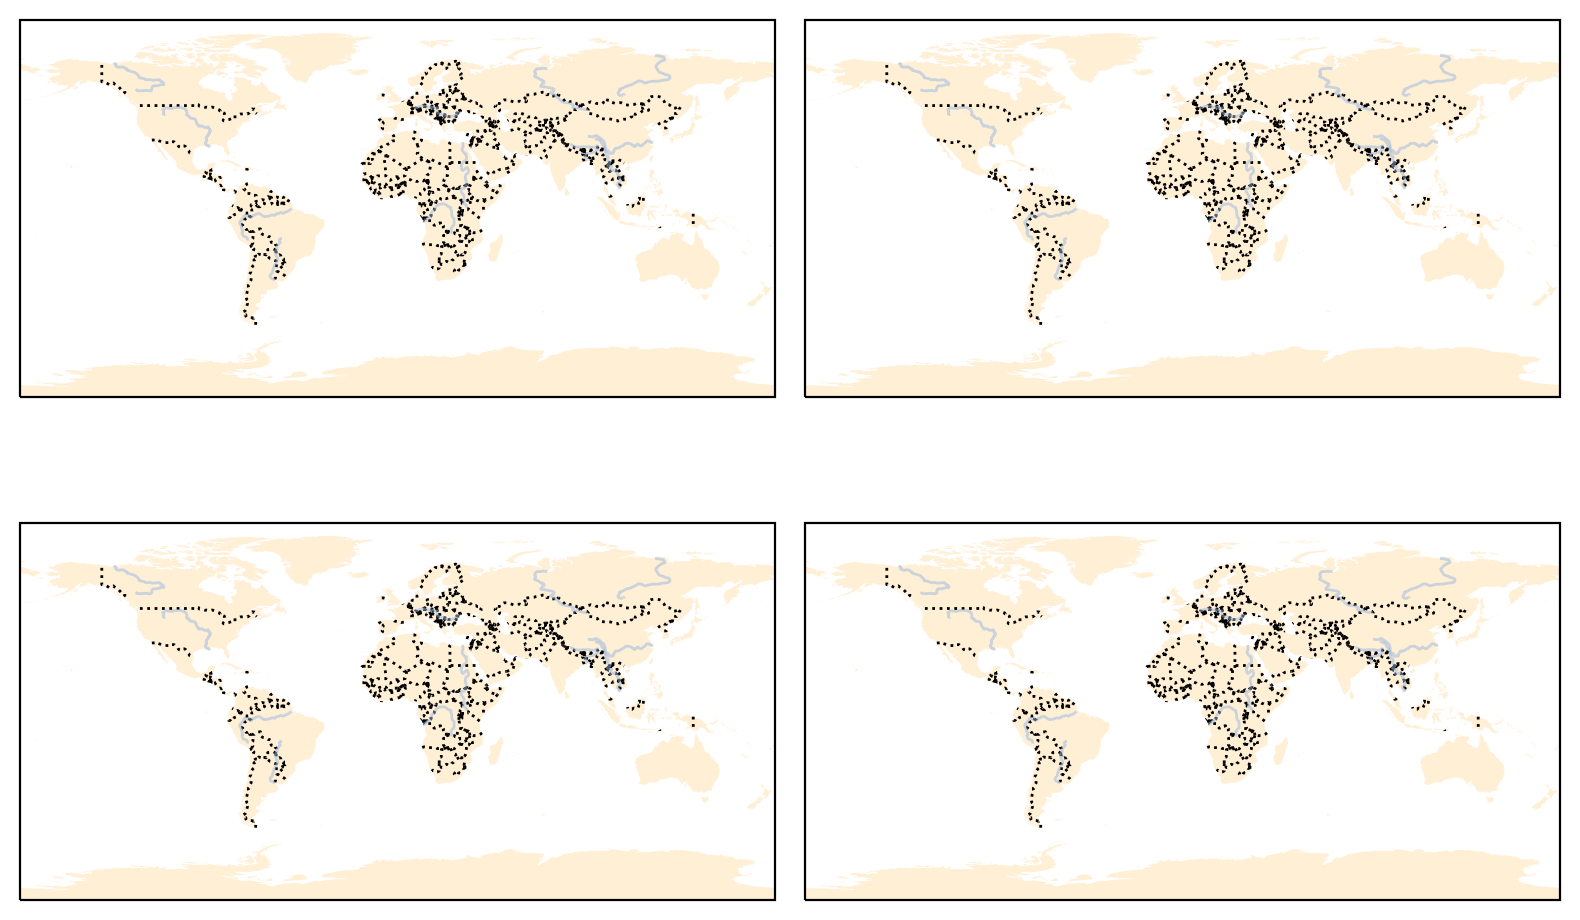

In [88]:
# 在子图建立时:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(8, 5.8), dpi=200,
    subplot_kw={'projection': ccrs.PlateCarree()}
)

for i, ax in enumerate(axes.flat):
    # ...（你的 imshow 绘图等）...

    # 添加一个统一的陆地背景
    land_feature = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',  # 或 '110m', '10m'
        facecolor='papayawhip'  # 你想要的颜色，可写 'lightgray', '#ffffcc' 等
    )
    ax.add_feature(land_feature, zorder=0)  # 在最底层

    # 或者直接用 cfeature.LAND, 自定义 facecolor
    # ax.add_feature(cfeature.LAND, facecolor='papayawhip', zorder=0)

    # 其他特征
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    # ...

plt.tight_layout()
plt.show()